# Loading Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy



In [ ]:
# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load image dataset

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/train', image_size=(32, 32))

Found 100000 files belonging to 2 classes.


# Visualizing  of sample set of images


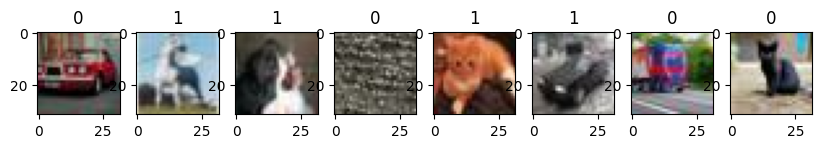

In [ ]:
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Normalizing the dataset for faster computation
To Normalize the data set I am # scaling pixel values to the range [0, 1]


In [ ]:
data = data.map(lambda x, y : (x/255, y))

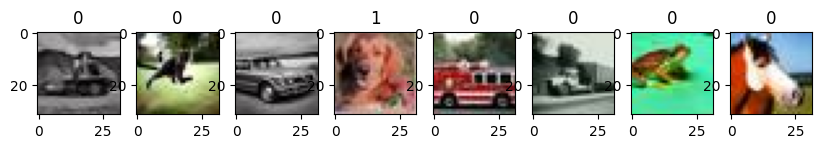

In [ ]:
# Showing scaled sample of images
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])


# Splitting Data to Train, Test, Validation

In [ ]:
train_size = int(len(data) * 0.7)
cv_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print("Train: ",len(train))
print("Test: ", len(test))
print("Val: ",len(cv))

Train:  2187
Test:  313
Val:  625


# Model Building
I have used pretrained ResNet50 as base model without freezing it's layers

In [ ]:
# Load pre-trained ResNet50 model base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Adjust the final layer according to your task

In [ ]:
# Overview of the Model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                      

In [ ]:
# Learning rate scheduler
initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Data Augumentation

In [ ]:

# Data Augmentation in the pipeline
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y
train_augmented = data.map(augment_data)



# Model Training

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_augmented, validation_data=cv, epochs=10, callbacks=[lr_schedule, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3125/3125 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8226

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3125/3125 [==============================] - 219s 60ms/step - loss: 0.4015 - accuracy: 0.8226 - val_loss: 0.3579 - val_accuracy: 0.8478 - lr: 9.5000e-04
Epoch 2/10
3125/3125 [==============================] - 184s 59ms/step - loss: 0.2704 - accuracy: 0.8914 - val_loss: 0.3997 - val_accuracy: 0.8411 - lr: 9.0250e-04
Epoch 3/10
3125/3125 [==============================] - 182s 58ms/step - loss: 0.2229 - accuracy: 0.9115 - val_loss: 0.1977 - val_accuracy: 0.9242 - lr: 8.5737e-04
Epoch 4/10
3125/3125 [==============================] - 182s 58ms/step - loss: 0.2010 - accuracy: 0.9219 - val_loss: 0.3286 - val_accuracy: 0.8571 - lr: 8.1451e-04
Epoch 5/10
3





# Plotting Model Accuracy & Loss

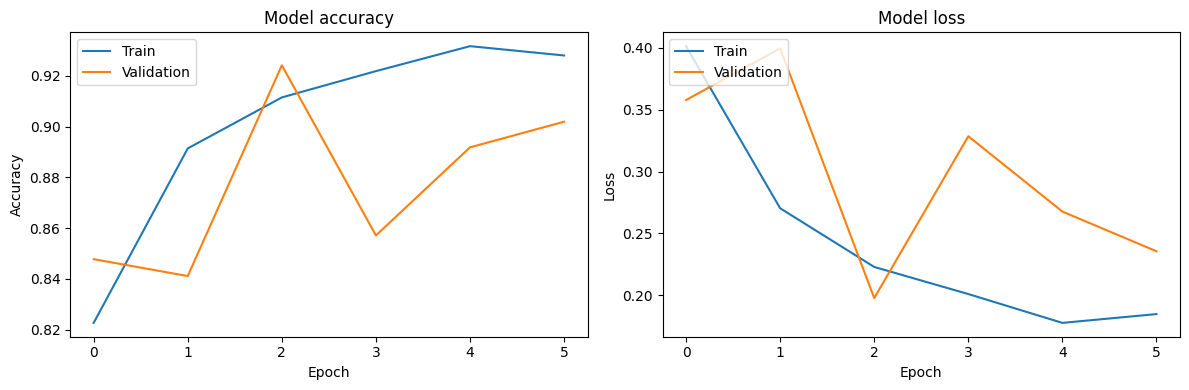

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# Precision, Recall & Accuracy

In [ ]:

pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 22ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 0.949883222579956, Recall: 0.8929926156997681, Accuracy: 0.9229233264923096


**Save & Loaded The Model**

In [ ]:

# Assuming 'model' is your Keras model
model.save('model/ai_imageclassifier', save_format='tf')

loaded_model = tf.keras.models.load_model('model/ai_imageclassifier')


# Model Prediction On Any Single Image

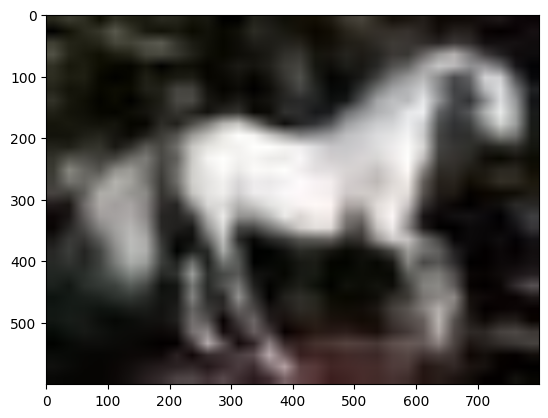

In [ ]:


# Load the image
image_path = '/content/test/REAL/0000 (8).jpg'

try:
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")
    img = cv2.resize(img, (800, 600))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

except Exception as e:
    print(f"Error: {e}")


In [ ]:
resize = tf.image.resize(img, (32, 32))
y_pred = model.predict(np.expand_dims(resize/255, 0))
y_pred


1/1 [==============================] - 0s 52ms/step


array([[0.8001781]], dtype=float32)

In [ ]:
if y_pred > 0.5:
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: AI')

Predicted class: REAL


# Classification Report & Confusion Matrix

1/1 [==============================] - 0s 35ms/step


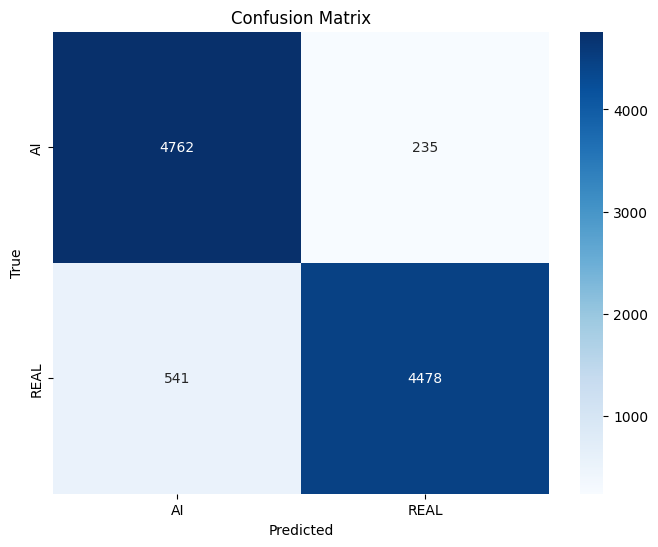

Classification Report:
               precision    recall  f1-score   support

          AI       0.90      0.95      0.92      4997
        REAL       0.95      0.89      0.92      5019

    accuracy                           0.92     10016
   macro avg       0.92      0.92      0.92     10016
weighted avg       0.92      0.92      0.92     10016



In [ ]:


# Evaluate the model on the test set
y_true = []
y_pred_probs = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred_probs.extend(model.predict(X).flatten())

# Convert probabilities to binary predictions
y_pred = np.array(y_pred_probs) > 0.5

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['AI', 'REAL'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'REAL'], yticklabels=['AI', 'REAL'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display Classification Report
print("Classification Report:\n", class_report)
